In [ ]:
# Changed data transforms
# Changed regularisation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Upload the zip file of the dataset
# !unzip -q -u "/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/data/train.zip" -d "/content/train"
!unzip -q -u "/content/drive/MyDrive/fish_are_mans_friend/data/train.zip" -d "/content/train"

In [3]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split, Dataset
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to upload the zip with the images (it is faster this way)
IMG_DIR = '/content/train/'

# Batch Size
BATCH_SIZE = 16

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [21]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the training and validation dataset
try:  
#   dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  dataset = datasets.ImageFolder(IMG_DIR)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))


class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)


train_dataset = CustomDataset(train_dataset, train_transform)
valid_dataset = CustomDataset(valid_dataset, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 8, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 8, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /content/train/
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


index:  0 0


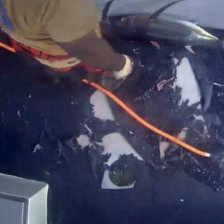

tensor(1)
index:  0 1


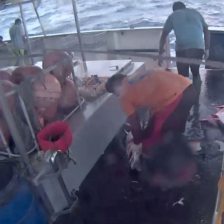

tensor(3)
index:  1 0


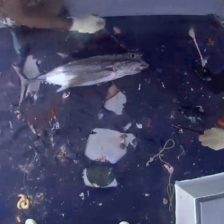

tensor(0)
index:  1 1


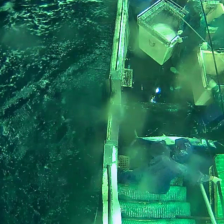

tensor(5)
index:  2 0


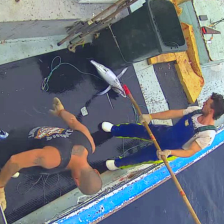

tensor(0)
index:  2 1


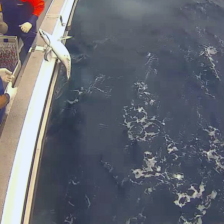

tensor(0)
index:  3 0


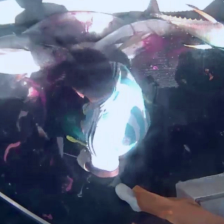

tensor(7)
index:  3 1


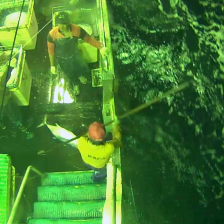

tensor(0)
index:  4 0


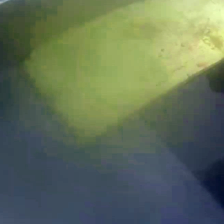

tensor(4)
index:  4 1


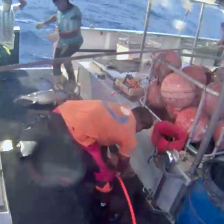

tensor(0)
index:  5 0


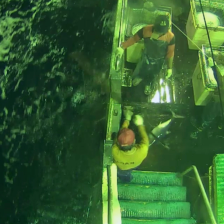

tensor(0)
index:  5 1


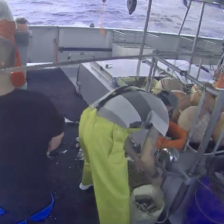

tensor(4)
index:  6 0


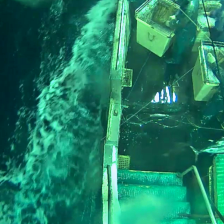

tensor(0)
index:  6 1


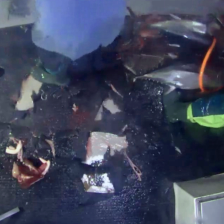

tensor(0)
index:  7 0


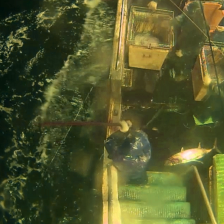

tensor(0)
index:  7 1


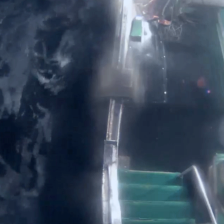

tensor(4)
index:  8 0


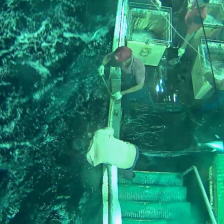

tensor(0)
index:  8 1


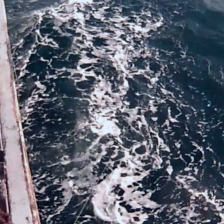

tensor(7)
index:  9 0


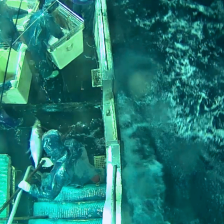

tensor(0)
index:  9 1


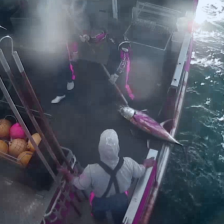

tensor(7)
index:  10 0


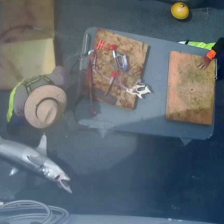

tensor(6)
index:  10 1


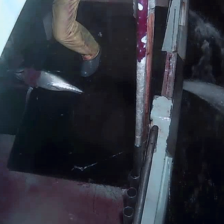

tensor(0)
index:  11 0


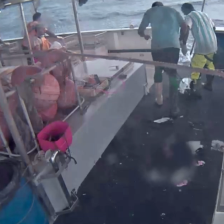

tensor(0)
index:  11 1


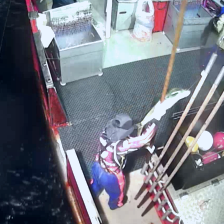

tensor(2)
index:  12 0


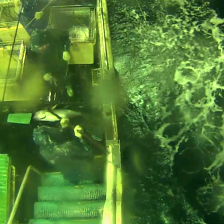

tensor(7)
index:  12 1


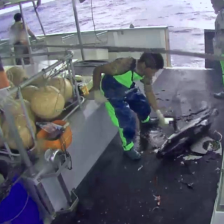

tensor(7)
index:  13 0


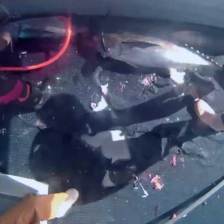

tensor(7)
index:  13 1


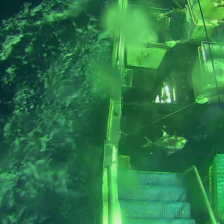

tensor(5)
index:  14 0


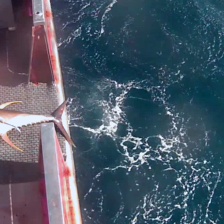

tensor(7)
index:  14 1


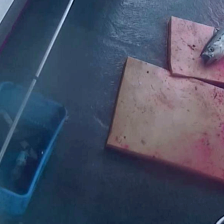

tensor(0)


In [22]:
from google.colab.patches import cv2_imshow
import cv2

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
a = 0
for i in train_dataloader:
    for j in range(len(i)):
        print("index: ", a, j)
        img = i[0][j].numpy().transpose((1, 2, 0))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2_imshow(img)
        print(i[1][j])

    a += 1
    if a == 15:
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


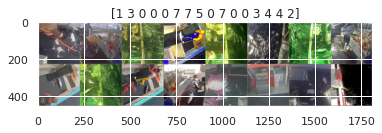

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrows=20)
imshow(out,title=classes.numpy())

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

print(efficientnet)

cuda


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [25]:
def weight_builder(label_map,data_size):
  weights = []
  normalised_weights = []
  asdf = 0
  for value in label_map.values():
    weights.append(1/(len(glob.glob(f"{IMG_DIR}/{value}/*"))/data_size))
  normalised_weights = [weight/sum(weights) for weight in weights]
  return normalised_weights

In [26]:
# Freeze model parameters because they were trained already
for param in efficientnet.parameters():
    param.requires_grad = False

# Change the final layer of Model for Transfer Learning
# Here the size of each output sample is set to 8
def augment_model(efficientnet):
    efficientnet.classifier[-1] = nn.Linear(in_features=1792, out_features=len(label_map), bias=True)
    return efficientnet

efficientnet = augment_model(efficientnet)

efficientnet = efficientnet.to(device)
# Create weights to handle class imbalance
weights = weight_builder(label_map,data_size)
# added weights to crossentropyloss for class imbalance
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
# We will use ADAM as our opitimiser
# Add regularisation
optimizer_ft = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-5)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
# # Test dataloader speed
# for index, i in enumerate(train_dataloader):
#     print(index, end=", ")
#     if index % 20 == 0:
#         print()

In [28]:
import copy
import time
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

efficientnet_classifier_done = train_model(efficientnet, loss_fn, optimizer_ft, exp_lr_scheduler,
                               num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.6816 Acc: 0.4116
val Loss: 1.3821 Acc: 0.4874

Epoch 1/9
----------
train Loss: 1.2606 Acc: 0.5050
val Loss: 1.1297 Acc: 0.5682

Epoch 2/9
----------
train Loss: 1.0886 Acc: 0.5652
val Loss: 1.0263 Acc: 0.5695

Epoch 3/9
----------
train Loss: 0.9794 Acc: 0.5824
val Loss: 0.9587 Acc: 0.6026

Epoch 4/9
----------
train Loss: 0.9096 Acc: 0.6145
val Loss: 0.9053 Acc: 0.6119

Epoch 5/9
----------
train Loss: 0.8317 Acc: 0.6340
val Loss: 0.8710 Acc: 0.6477

Epoch 6/9
----------
train Loss: 0.7876 Acc: 0.6522
val Loss: 0.8568 Acc: 0.6517

Epoch 7/9
----------
train Loss: 0.7585 Acc: 0.6668
val Loss: 0.8412 Acc: 0.6517

Epoch 8/9
----------
train Loss: 0.7353 Acc: 0.6645
val Loss: 0.8466 Acc: 0.6503

Epoch 9/9
----------
train Loss: 0.7594 Acc: 0.6608
val Loss: 0.8318 Acc: 0.6556

Training complete in 21m 14s
Best val Acc: 0.655629


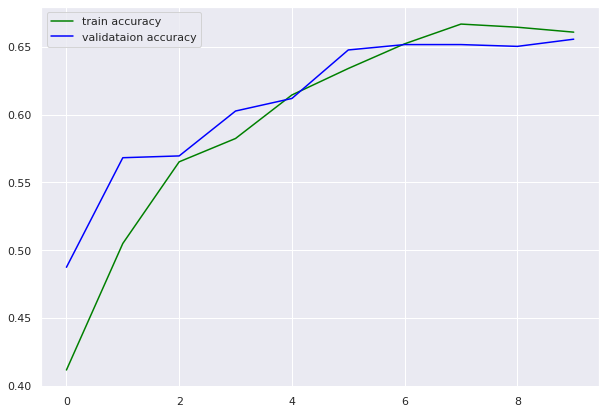

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('./images/train_val_accuracy.png')
plt.show()

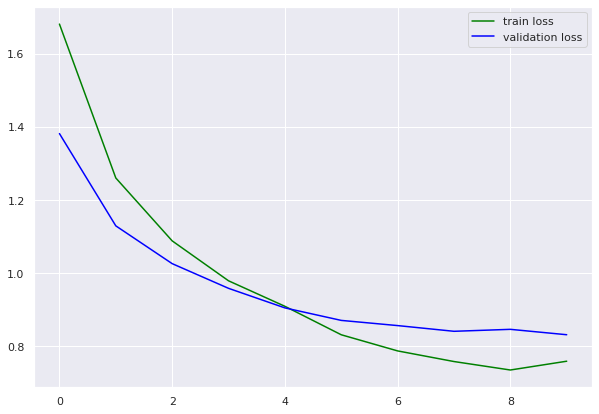

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validation loss')
plt.legend()
plt.savefig('./images/train_val_loss.png')
plt.show()

In [33]:
# Train the model as a whole
for param in efficientnet.parameters():
    param.requires_grad = True

# We will use ADAM as our opitimiser
# Add regularisation
optimizer_final = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-5)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler_final = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

efficientnet_final = train_model(efficientnet_classifier_done, loss_fn, optimizer_final, 
                                 exp_lr_scheduler_final, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8450 Acc: 0.6655


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 0.6044 Acc: 0.6583

Epoch 1/24
----------
train Loss: 0.3386 Acc: 0.8359
val Loss: 0.5595 Acc: 0.8702

Epoch 2/24
----------
train Loss: 0.1698 Acc: 0.9153
val Loss: 0.5614 Acc: 0.8927

Epoch 3/24
----------
train Loss: 0.0932 Acc: 0.9504
val Loss: 0.3413 Acc: 0.9192

Epoch 4/24
----------
train Loss: 0.0905 Acc: 0.9543
val Loss: 0.4203 Acc: 0.9192

Epoch 5/24
----------
train Loss: 0.1557 Acc: 0.9279
val Loss: 0.7797 Acc: 0.8570

Epoch 6/24
----------
train Loss: 0.0909 Acc: 0.9560
val Loss: 0.4929 Acc: 0.8940

Epoch 7/24
----------
train Loss: 0.3407 Acc: 0.8723
val Loss: 1.0828 Acc: 0.7033

Epoch 8/24
----------
train Loss: 0.1231 Acc: 0.9325
val Loss: 0.3303 Acc: 0.9285

Epoch 9/24
----------
train Loss: 0.0551 Acc: 0.9752
val Loss: 0.4626 Acc: 0.8636

Epoch 10/24
----------
train Loss: 0.0676 Acc: 0.9636
val Loss: 0.9515 Acc: 0.8013

Epoch 11/24
----------
train Loss: 0.3080 Acc: 0.8812
val Loss: 1.1882 Acc: 0.7020

Epoch 12/24
----------
train Loss: 0.1624 Acc: 0.9179
v

In [34]:
# If the above meet into cuda memory errors, run the following to clear some memory
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

44

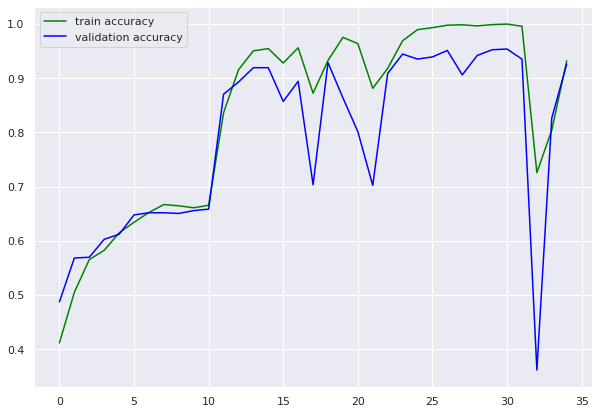

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validation accuracy')
plt.legend()
plt.savefig('./images/train_val_accuracy_final.png')
plt.show()

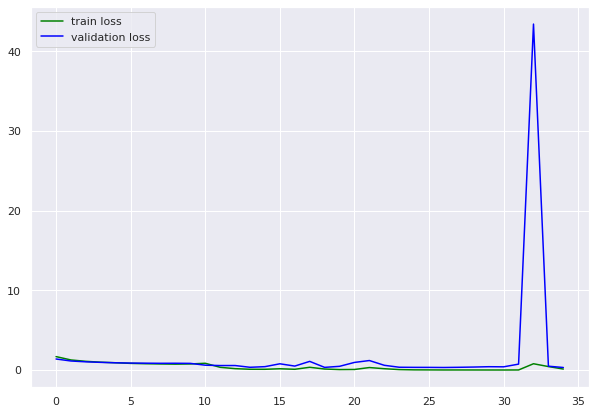

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validation loss')
plt.legend()
plt.savefig('./images/train_val_loss_final.png')
plt.show()

In [39]:
# save_path = "/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/models/efficientnet_03_full.pt"
# save_path = "/content/drive/MyDrive/fish_are_mans_friend/models/efficientnet_03_full.pt"
save_path_state_dict = "/content/drive/MyDrive/fish_are_mans_friend/models/efficientnet_03_full_state_dict.pt"


# torch.save(efficientnet_final, save_path)
torch.save(efficientnet_final.state_dict(), save_path_state_dict)

In [ ]:
load_path = ;

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)

model = augment_model(efficientnet)
model.load_state_dict(torch.load(PATH))
model.eval()